<a href="https://colab.research.google.com/github/jdmartinev/MachineLearning/blob/main/Talleres/1_Regresi%C3%B3n_con_RF_y_GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Taller 1: Regresión con Random Forest y Gradient Boosting


En este taller se aplicará ensambes de árboles de decisión tipo random forest y gradient boosting a un conjunto de datos de jugadores del video juego FIFA 19. Los datos utilizados son un subconjunto modificado de [este set de datos](https://www.kaggle.com/karangadiya/fifa19) y se encuentran en el archivo `FIFA 19 players.csv`. La tarea a realizar consiste en predecir el salario (wage) de los jugadores.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from matplotlib import pyplot as plt

In [2]:
# Obtenemos los datos
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE' -O players.csv

--2024-03-04 16:01:59--  https://docs.google.com/uc?export=download&id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE
Resolving docs.google.com (docs.google.com)... 142.250.218.142, 2800:3f0:4005:40e::200e
Connecting to docs.google.com (docs.google.com)|142.250.218.142|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE&export=download [following]
--2024-03-04 16:01:59--  https://drive.usercontent.google.com/download?id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.135.161, 2800:3f0:4005:40c::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.135.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5036558 (4.8M) [application/octet-stream]
Saving to: ‘players.csv’

players.csv         100%[===================>]   4.80M  9.94MB/s    in 0.5s    

In [3]:
# Definamos el "random_state" para que los resultados sean reproducibles:
random_state = 42

In [4]:
# Cambiemos la fuente de las gráficas de matplotlib:
plt.rc("font", family="serif", size=12)

## Preprocesamiento de datos


In [5]:
# Carguemos los datos:
data = pd.read_csv("players.csv")
data

,Name,Age,Overall,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,L. Messi,31,94,565000,Left,5.0,4.0,4.0,90.0,90.0,...,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0
1,Cristiano Ronaldo,33,94,405000,Right,5.0,4.0,5.0,94.0,94.0,...,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0
2,Neymar Jr,26,92,290000,Right,5.0,5.0,5.0,87.0,87.0,...,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0
3,K. De Bruyne,27,91,355000,Right,4.0,5.0,4.0,85.0,85.0,...,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0
4,E. Hazard,27,91,340000,Right,4.0,4.0,4.0,86.0,86.0,...,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15921,J. Lundstram,19,47,1000,Right,1.0,2.0,2.0,44.0,44.0,...,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0
15922,N. Christoffersson,19,47,1000,Right,1.0,2.0,2.0,47.0,47.0,...,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,19.0
15923,B. Worman,16,47,1000,Right,1.0,3.0,2.0,47.0,47.0,...,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,11.0
15924,D. Walker-Rice,17,47,1000,Right,1.0,3.0,2.0,49.0,49.0,...,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,27.0


In [6]:
# Veamos la descripción del dataset:
data.describe(include="all")

,Name,Age,Overall,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
count,15926,15926.000000,15926.000000,15926.000000,15926,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,...,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.00000,15926.000000,15926.000000,15926.000000
unique,15114,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,J. Rodríguez,NaN,NaN,NaN,Right,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,9,NaN,NaN,NaN,11969,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,24.991209,66.446189,10254.866256,NaN,1.116037,3.004081,2.533342,59.842647,59.842647,...,51.446126,59.575411,50.401168,54.844405,55.494726,52.118234,60.34654,51.273703,51.883021,49.593118
std,NaN,4.552866,6.809244,22692.769542,NaN,0.397762,0.636845,0.618186,9.141407,9.141407,...,15.718376,14.432944,18.797738,14.665434,12.897478,12.501841,10.14202,17.198926,19.161875,19.162508
min,NaN,16.000000,46.000000,1000.000000,NaN,1.000000,1.000000,2.000000,33.000000,33.000000,...,11.000000,13.000000,10.000000,11.000000,12.000000,12.000000,29.00000,10.000000,10.000000,10.000000
25%,NaN,21.000000,62.000000,1000.000000,NaN,1.000000,3.000000,2.000000,54.000000,54.000000,...,40.000000,50.000000,34.000000,46.000000,47.000000,42.000000,53.00000,37.000000,35.000000,32.000000
50%,NaN,25.000000,66.000000,3000.000000,NaN,1.000000,3.000000,2.000000,60.000000,60.000000,...,54.000000,61.000000,56.000000,57.000000,57.000000,52.000000,61.00000,56.000000,59.000000,56.000000
75%,NaN,28.000000,71.000000,10000.000000,NaN,1.000000,3.000000,3.000000,66.000000,66.000000,...,64.000000,70.000000,65.000000,65.000000,65.000000,61.000000,68.00000,65.000000,67.000000,65.000000


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Overall'}>,
        <Axes: title={'center': 'Wage'}>,
        <Axes: title={'center': 'International Reputation'}>,
        <Axes: title={'center': 'Weak Foot'}>,
        <Axes: title={'center': 'Skill Moves'}>,
        <Axes: title={'center': 'LS'}>, <Axes: title={'center': 'ST'}>],
       [<Axes: title={'center': 'RS'}>, <Axes: title={'center': 'LW'}>,
        <Axes: title={'center': 'LF'}>, <Axes: title={'center': 'CF'}>,
        <Axes: title={'center': 'RF'}>, <Axes: title={'center': 'RW'}>,
        <Axes: title={'center': 'LAM'}>, <Axes: title={'center': 'CAM'}>],
       [<Axes: title={'center': 'RAM'}>, <Axes: title={'center': 'LM'}>,
        <Axes: title={'center': 'LCM'}>, <Axes: title={'center': 'CM'}>,
        <Axes: title={'center': 'RCM'}>, <Axes: title={'center': 'RM'}>,
        <Axes: title={'center': 'LWB'}>, <Axes: title={'center': 'LDM'}>],
       [<Axes: title={'center': 'CDM'}>, <Axes: title={'

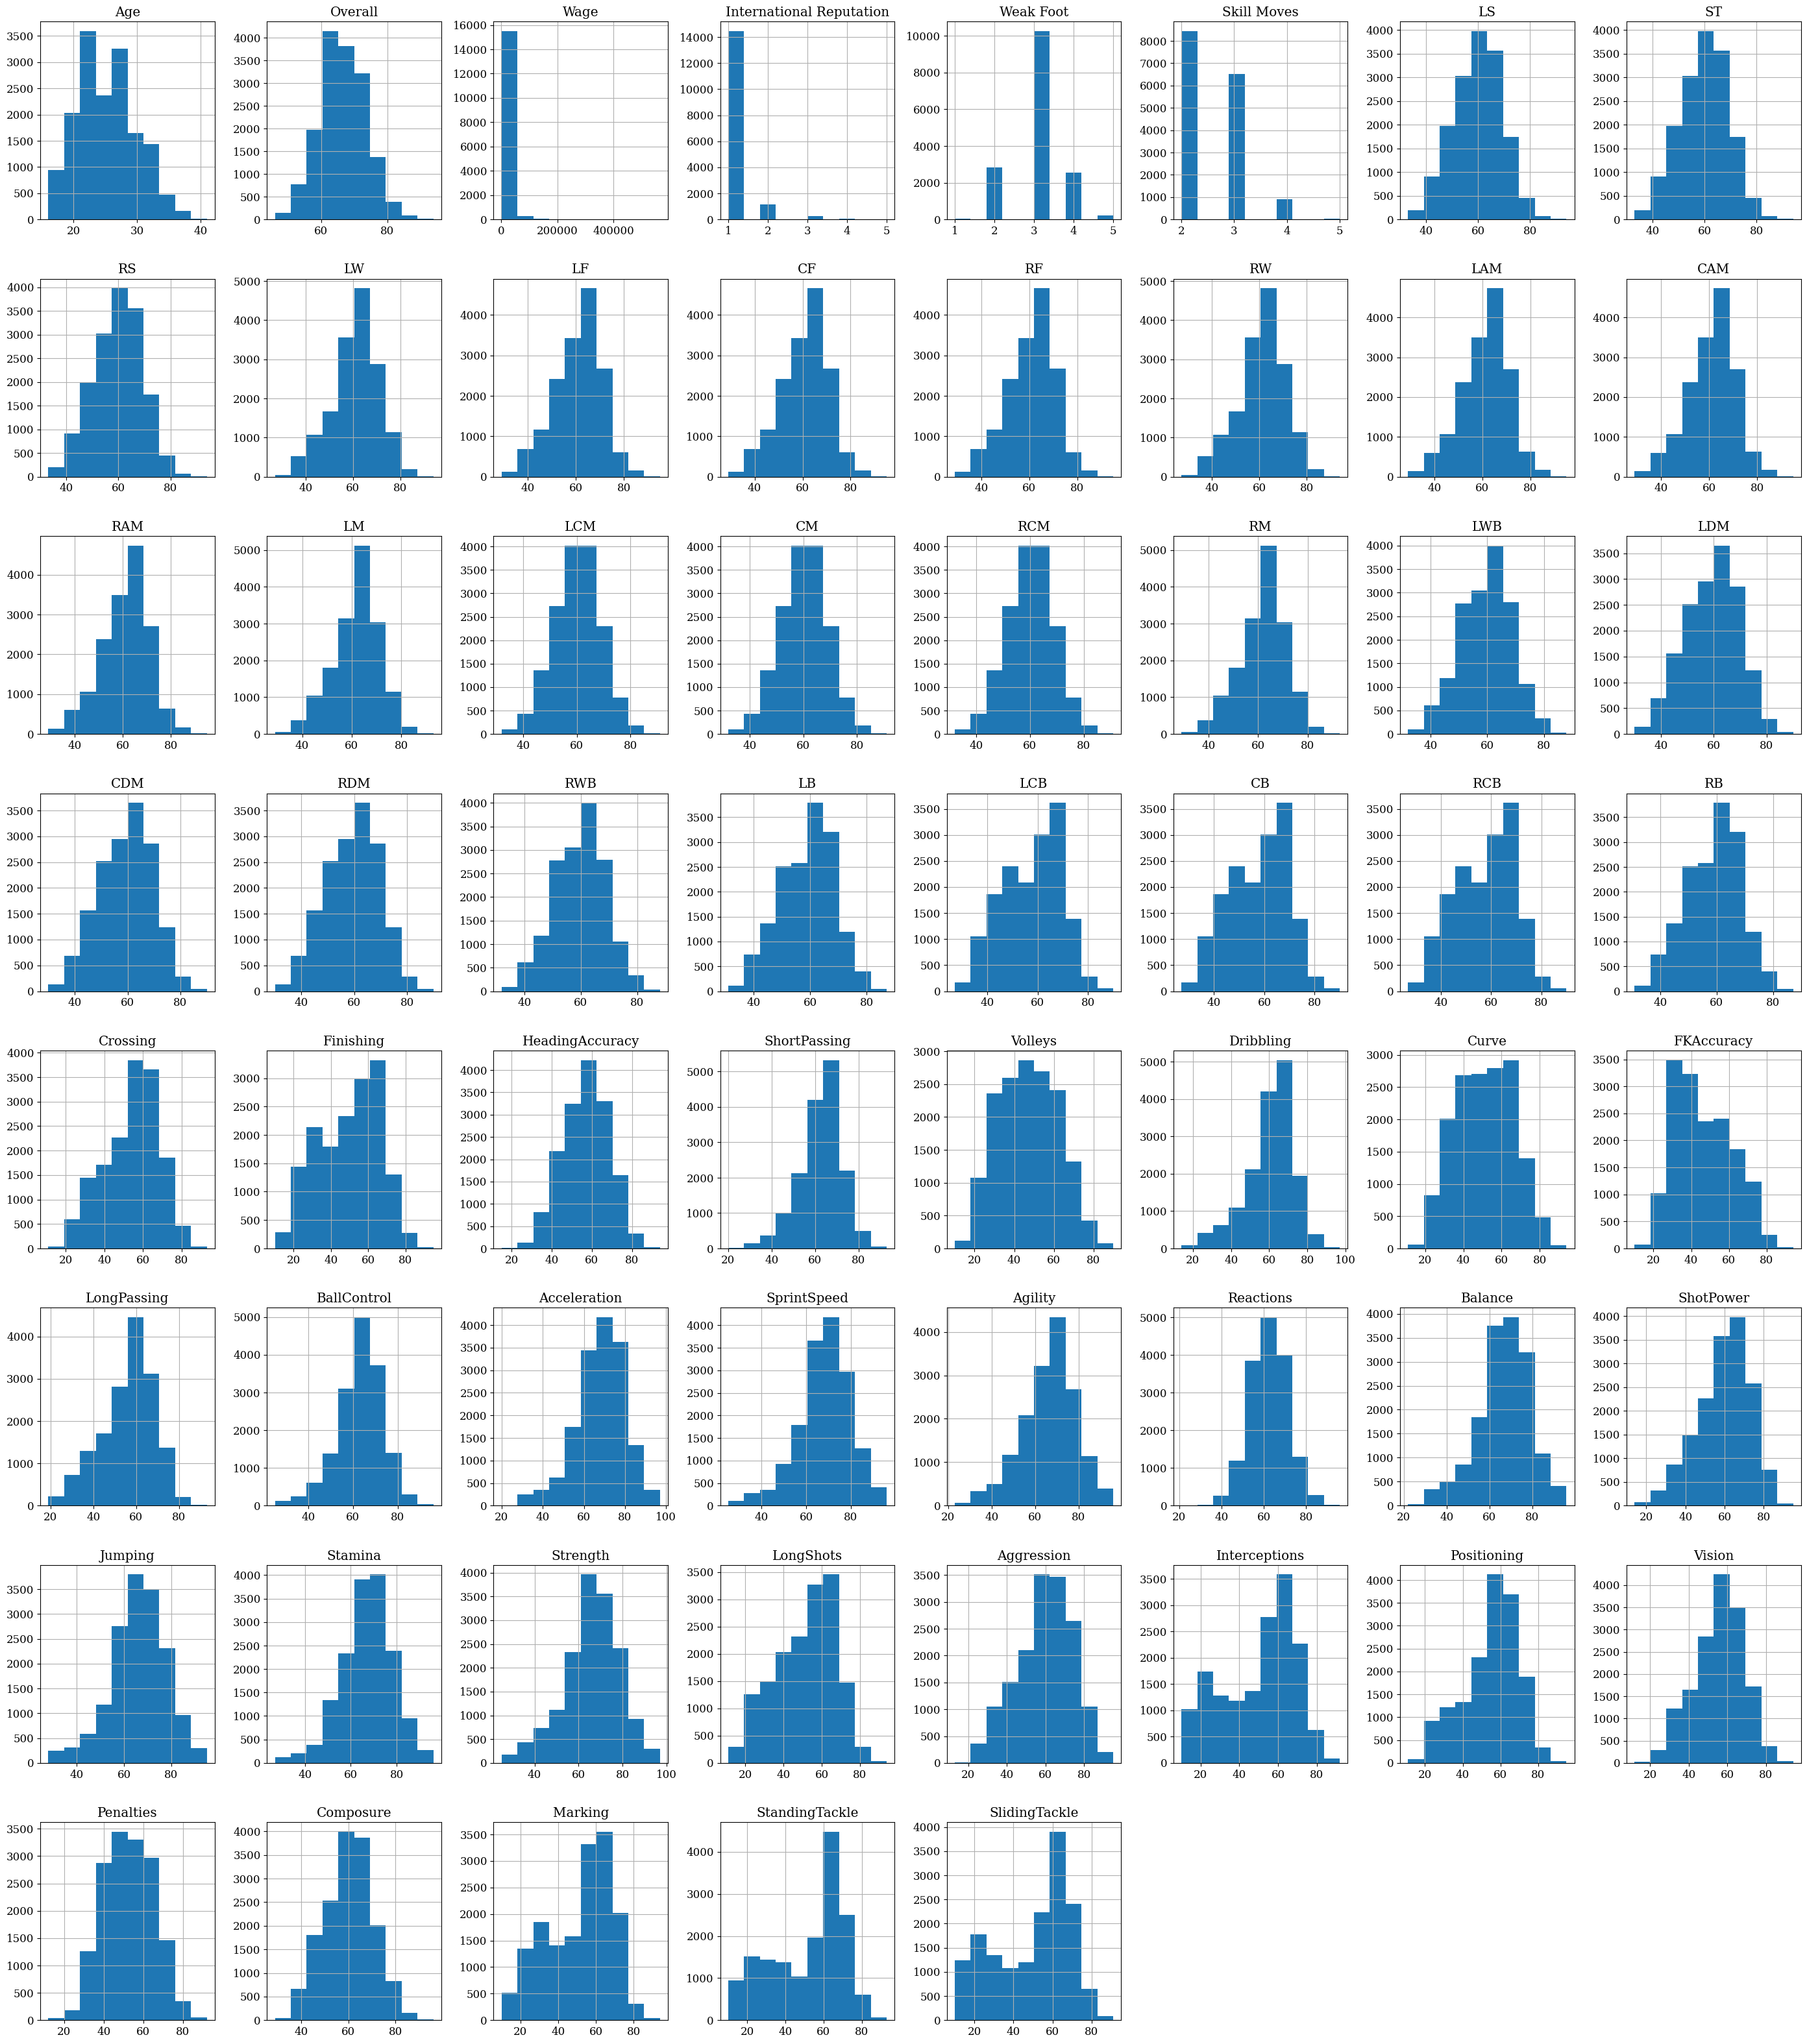

In [7]:
data.hist(figsize=(35, 40))

<Axes: xlabel='Preferred Foot'>

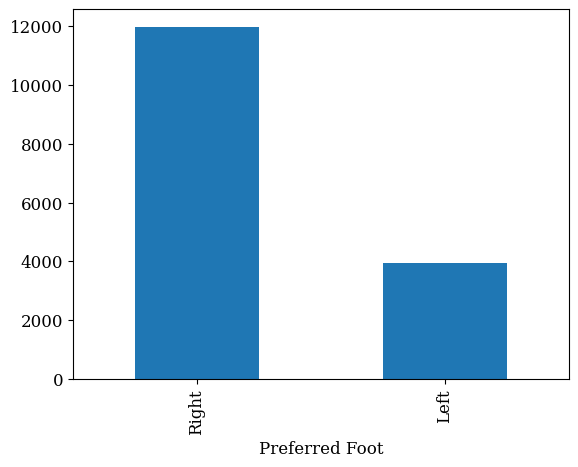

In [8]:
# Obtengamos la distribución de valores de la variable `Preferred Foot`:
# tip: pandas function value_counts()
data["Preferred Foot"].value_counts().plot(kind="bar")

In [9]:
# Dado que esta columna es categorica, debemos incluir en el Pipeline su transformación. Utilizaremos
# codificación binaria
# tip: scikit-learn BinaryEncoder -> Igual funcionamiento a OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## Regresión


**Nota:** Dejaremos la coulmna `Name` en el dataframe para poder identificar a los jugadores, pero **la debemos excluir** al definir las variables `X_train`, `y_train`, `X_val`, `y_val`, `X_test`, and `y_test`.


In [10]:
# Separemos los datos en conjuntos de entrenamiento (80 %) y prueba (20 %):
from sklearn.model_selection import train_test_split

X = data.drop(columns=["Name", "Wage"])
y = data["Wage"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

In [11]:
# Definimos las transformaciones
cat_cols = X_train.select_dtypes(include=object).columns

categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        )
    ]
)
numerical_transformer = "passthrough"

preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, cat_cols)],
    remainder=numerical_transformer,
)

# Definimos nuestro regresor
rf_base = RandomForestRegressor(random_state=random_state)
gb_base = GradientBoostingRegressor(random_state=random_state)

# Definimos los pipelines
pipeline_rf = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", rf_base)])
pipeline_gb = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", gb_base)])

# Definamos la malla de parámetros sobre la que haremos la búsqueda:
param_grid = {
    "regressor__n_estimators": [50, 100],
    "regressor__max_depth": list(range(6, 10)),
    "regressor__min_samples_leaf": [10, 300, 2000],
}

# Definamos nuestros modelo mediante GridSearchCV:
rf = GridSearchCV(pipeline_rf, cv=3, param_grid=param_grid)
gb = GridSearchCV(pipeline_gb, cv=3, param_grid=param_grid)

In [12]:
%%time
# Entrenemos el random forest:
rf.fit(X_train, y_train)
# Entrenemos el gradient boosting:
gb.fit(X_train, y_train)

CPU times: user 9min 32s, sys: 74 ms, total: 9min 32s
Wall time: 9min 32s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         Index(['Preferred Foot'], dtype='object'))])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [6, 7, 8, 9],
                         'regressor__min_samples_leaf': [10, 300, 2000],
                         'regressor__n_estimators': [50, 100]})

In [13]:
print(rf.best_params_)
print(gb.best_params_)

{'regressor__max_depth': 8, 'regressor__min_samples_leaf': 10, 'regressor__n_estimators': 50}
{'regressor__max_depth': 6, 'regressor__min_samples_leaf': 10, 'regressor__n_estimators': 50}


In [14]:
# Obtengamos el R^2 y el MAE de entrenamiento para cada modelo:
print("Train set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f"R^2: {model.score(X_train, y_train)}")
    print(f"MAE: {mean_absolute_error(y_train, model.predict(X_train))}")
    print("\n")

print("Test set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f"R^2: {model.score(X_test, y_test)}")
    print(f"MAE: {mean_absolute_error(y_test, model.predict(X_test))}")
    print("\n")

Train set
Model: Random Forest
R^2: 0.832303072236548


MAE: 4170.219240658308


Model: Gradient Boosting
R^2: 0.9008905464935486
MAE: 3724.0274088205706


Test set
Model: Random Forest
R^2: 0.7796619928039111
MAE: 4747.574783447521


Model: Gradient Boosting
R^2: 0.7842995092307057
MAE: 4733.454878591794




In [15]:
# Veamos los datos junto con las predicciones:
pd.concat(
    [
        data.drop(columns="Wage").reset_index(drop=True),
        data["Wage"].reset_index(drop=True),
        pd.DataFrame(
            {"rf_predicted_wage": rf.predict(data.drop(columns=["Name", "Wage"]))}
        ),
        pd.DataFrame(
            {"gb_predicted_wage": gb.predict(data.drop(columns=["Name", "Wage"]))}
        ),
    ],
    axis=1,
)

,Name,Age,Overall,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,RS,...,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Wage,rf_predicted_wage,gb_predicted_wage
0,L. Messi,31,94,Left,5.0,4.0,4.0,90.0,90.0,90.0,...,94.0,94.0,75.0,96.0,33.0,28.0,26.0,565000,297521.493056,329238.805747
1,Cristiano Ronaldo,33,94,Right,5.0,4.0,5.0,94.0,94.0,94.0,...,95.0,82.0,85.0,95.0,28.0,31.0,23.0,405000,295231.950572,376613.981214
2,Neymar Jr,26,92,Right,5.0,5.0,5.0,87.0,87.0,87.0,...,89.0,87.0,81.0,94.0,27.0,24.0,33.0,290000,297521.493056,310379.559388
3,K. De Bruyne,27,91,Right,4.0,5.0,4.0,85.0,85.0,85.0,...,87.0,94.0,79.0,88.0,68.0,58.0,51.0,355000,297521.493056,340445.337484
4,E. Hazard,27,91,Right,4.0,4.0,4.0,86.0,86.0,86.0,...,87.0,89.0,86.0,91.0,34.0,27.0,22.0,340000,297521.493056,324918.106145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15921,J. Lundstram,19,47,Right,1.0,2.0,2.0,44.0,44.0,44.0,...,39.0,52.0,43.0,45.0,40.0,48.0,47.0,1000,1100.427370,1619.661953
15922,N. Christoffersson,19,47,Right,1.0,2.0,2.0,47.0,47.0,47.0,...,46.0,33.0,43.0,42.0,22.0,15.0,19.0,1000,1111.989645,1619.661953
15923,B. Worman,16,47,Right,1.0,3.0,2.0,47.0,47.0,47.0,...,48.0,43.0,55.0,41.0,32.0,13.0,11.0,1000,1118.197063,1619.661953
15924,D. Walker-Rice,17,47,Right,1.0,3.0,2.0,49.0,49.0,49.0,...,44.0,47.0,50.0,46.0,20.0,25.0,27.0,1000,1100.427370,1619.661953


Explicabilidad


In [16]:
%pip install shap

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [17]:
import shap
from IPython.display import HTML

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [18]:
# Entrenamos nuestro pipeline con los mejores parámetros encontrados en la validación cruzada
pipeline_gb.set_params(**gb.best_params_)
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['Preferred Foot'], dtype='object'))])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=6, min_samples_leaf=10,
                                           n_estimators=50, random_state=42))])

In [19]:
# Aplicamos el preproceso a los datos
X_train_preprocessed = pipeline_gb.named_steps["preprocessor"].transform(X_train)
X_test_preprocessed = pipeline_gb.named_steps["preprocessor"].transform(X_test)

In [20]:
# Entrenemos nuestro modelo de explicabilidad
gb_explainer = shap.TreeExplainer(pipeline_gb.named_steps["regressor"])
train_gb_shap_values = gb_explainer.shap_values(X_train_preprocessed)

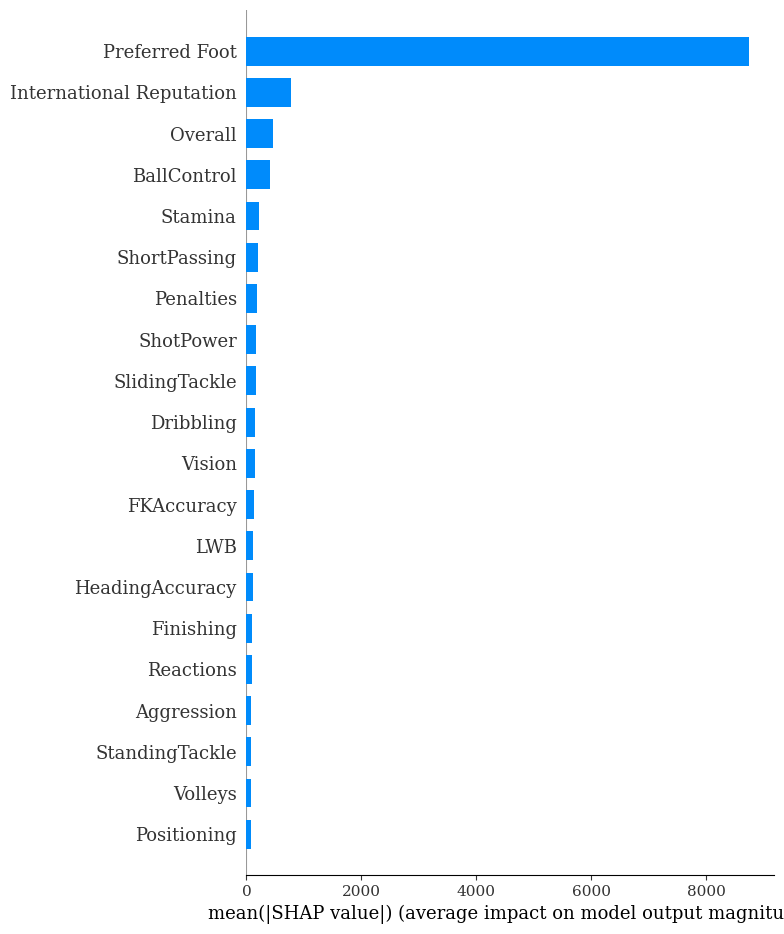

In [24]:
# Summary plot
test_gb_shap_values = gb_explainer.shap_values(X_test_preprocessed)
shap.summary_plot(test_gb_shap_values, X_test, plot_type="bar")

In [25]:
# Grafiquemos los valores SHAP para un ejemplo del conjunto de test
shap.initjs()

# Individual SHAP value plot for a specific instance (e.g., the first instance in the test set)
instance_index = 0
force_plot_html = shap.force_plot(
    gb_explainer.expected_value,
    test_gb_shap_values[instance_index],
    X_test.iloc[instance_index],
    show=False,
)
HTML(force_plot_html.html())

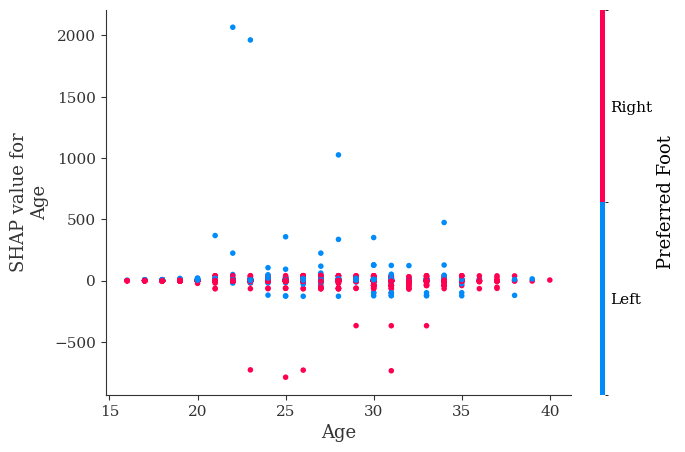

In [26]:
# Grafiquemos la dependencia de los valores SHAP con la variable "Age"
shap.dependence_plot("Age", test_gb_shap_values, X_test)